In [1]:
from policy_gradient import PolicyGradient
import matplotlib.pyplot as plt

In [7]:
import random
import numpy as np
from statistics import median, mean
from collections import Counter

In [44]:
from IPython.display import clear_output # only for jupyter notebook
from time import sleep
import pickle

In [9]:
# import game env
from puzzle import GameGrid
env = GameGrid()
env.reset()

[[0, 0, 0, 0], [2, 0, 2, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

In [36]:
RENDER_ENV = False
EPISODES = 10000
rewards = []
max_episode_values = []
RENDER_REWARD_MIN = 50
LR = 0.01

In [24]:
load_path = None #"output/weights/CartPole-v0.ckpt"
save_path = "output/weights/experiment2.ckpt"

PG = PolicyGradient(
    n_x = 16,
    n_y = 4,
    learning_rate=LR,
    reward_decay=0.95,
    load_path=load_path,
    save_path=save_path
)

ValueError: Variable W1 already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Users/arihantparsoya/Documents/Advanced ML/Project/CS726-Project-2048-Using-RL/policy_gradient.py", line 127, in build_network
    W1 = tf.get_variable("W1", [units_layer_1, self.n_x], initializer = tf.contrib.layers.xavier_initializer(seed=1))
  File "/Users/arihantparsoya/Documents/Advanced ML/Project/CS726-Project-2048-Using-RL/policy_gradient.py", line 23, in __init__
    self.build_network()
  File "<ipython-input-11-e83570ae00d6>", line 10, in <module>
    save_path=save_path


In [12]:
def convertTo1D(matrix):
    return np.array(np.array(matrix).flatten().tolist())

In [ ]:
for episode in range(EPISODES):
    obs = env.reset()
    observation = convertTo1D(obs)
    episode_reward = 0
    episode_max_value = 0
    
    while True:
        if RENDER_ENV:
            clear_output()
            env.display_state()
            sleep(0.5)
            
        # 1. Choose an action based on observation
        action = PG.choose_action(observation)
        
        # 2. Take action in the environment
        obs_, reward, done, info = env.step(action.item())
        obs_ = convertTo1D(obs_)
        
        # check if it is unfeasible move
        if np.array_equal(observation, obs_):
            # use another random move
            action = random.randrange(0,4)
            obs_, reward, done, info = env.step(action)
            obs_ = convertTo1D(obs_)
            
        # 3. Store transition for training
        PG.store_transition(observation, action, reward)
        
        # 4. Save new observation
        observation = obs_
        
        # 5. Save max value in the game
        if episode_max_value < env.highest_score():
            episode_max_value = env.highest_score()
        
        if done:
            episode_rewards_sum = sum(PG.episode_rewards)
            rewards.append(episode_rewards_sum)
            max_reward_so_far = np.amax(rewards)
            
            max_episode_values.append(episode_max_value)

            #print("==========================================")
            print("Episode: ", episode)
            #print("Reward: ", episode_rewards_sum)
            #print("Max reward so far: ", max_reward_so_far)

            # 4. Train neural network
            discounted_episode_rewards_norm = PG.learn()

            # Render env if we get to rewards minimum
            #if max_reward_so_far > RENDER_REWARD_MIN: RENDER_ENV = True
            break

Episode:  0
Reward:  4189.180000000001
Max reward so far:  4189.180000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1
Reward:  4679.500000000002
Max reward so far:  4679.500000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  2
Reward:  28797.04
Max reward so far:  28797.04
Model saved in file: output/weights/experiment2.ckpt
Episode:  3
Reward:  11295.199999999999
Max reward so far:  28797.04
Model saved in file: output/weights/experiment2.ckpt
Episode:  4
Reward:  21279.06
Max reward so far:  28797.04
Model saved in file: output/weights/experiment2.ckpt
Episode:  5
Reward:  30741.280000000006
Max reward so far:  30741.280000000006
Model saved in file: output/weights/experiment2.ckpt
Episode:  6
Reward:  7774.540000000002
Max reward so far:  30741.280000000006
Model saved in file: output/weights/experiment2.ckpt
Episode:  7
Reward:  32584.279999999995
Max reward so far:  32584.279999999995
Model saved in file: output/weights/experiment2.ckpt

Episode:  48
Reward:  11604.859999999999
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  49
Reward:  8535.52
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  50
Reward:  5663.499999999999
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  51
Reward:  1824.02
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  52
Reward:  10745.640000000001
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  53
Reward:  5289.419999999997
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  54
Reward:  8432.519999999999
Max reward so far:  34746.87999999999
Model saved in file: output/weights/experiment2.ckpt
Episode:  55
Reward:  7455.2199999999975
Max reward so far:  34746.87999999999
Model saved in file: o

Episode:  96
Reward:  4533.74
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  97
Reward:  12545.740000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  98
Reward:  11900.920000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  99
Reward:  10384.159999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  100
Reward:  5289.519999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  101
Reward:  17221.100000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  102
Reward:  10681.46
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  103
Reward:  5001.340000000002
Max reward so far:  49804.259999999995
Model sa

Episode:  145
Reward:  17818.899999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  146
Reward:  21395.239999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  147
Reward:  2887.019999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  148
Reward:  4804.36
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  149
Reward:  2818.2599999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  150
Reward:  5582.199999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  151
Reward:  30925.360000000004
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  152
Reward:  15203.400000000005
Max reward so far:  49804.2599999

Episode:  194
Reward:  4106.080000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  195
Reward:  10429.059999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  196
Reward:  8019.959999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  197
Reward:  13029.859999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  198
Reward:  12742.239999999993
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  199
Reward:  40361.240000000005
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  200
Reward:  6653.86
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  201
Reward:  12114.859999999999
Max reward so far:  49804.2599999

Episode:  241
Reward:  4287.799999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  242
Reward:  10214.28
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  243
Reward:  9670.560000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  244
Reward:  5854.62
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  245
Reward:  22780.120000000003
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  246
Reward:  3963.380000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  247
Reward:  1680.74
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  248
Reward:  6299.099999999999
Max reward so far:  49804.259999999995
Model saved in fi

Episode:  290
Reward:  12180.2
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  291
Reward:  7334.620000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  292
Reward:  10277.66
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  293
Reward:  3426.3
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  294
Reward:  9288.899999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  295
Reward:  3967.8399999999992
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  296
Reward:  9126.18
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  297
Reward:  21610.460000000003
Max reward so far:  49804.259999999995
Model saved in file: output

Model saved in file: output/weights/experiment2.ckpt
Episode:  339
Reward:  12269.659999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  340
Reward:  30264.120000000003
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  341
Reward:  5328.059999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  342
Reward:  14660.640000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  343
Reward:  10706.48
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  344
Reward:  15851.4
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  345
Reward:  5628.6
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  346
Reward:  3958.5800000000004
M

Episode:  387
Reward:  4466.339999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  388
Reward:  7036.519999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  389
Reward:  1756.7599999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  390
Reward:  22600.3
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  391
Reward:  15327.479999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  392
Reward:  3526.479999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  393
Reward:  10247.0
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  394
Reward:  14821.199999999997
Max reward so far:  49804.259999999995
Model 

Episode:  436
Reward:  3539.359999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  437
Reward:  11033.839999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  438
Reward:  4872.720000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  439
Reward:  10296.999999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  440
Reward:  2928.4800000000005
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  441
Reward:  8326.18
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  442
Reward:  13870.739999999994
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  443
Reward:  4569.0199999999995
Max reward so far:  49804.2599999

Model saved in file: output/weights/experiment2.ckpt
Episode:  485
Reward:  10276.740000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  486
Reward:  13554.36
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  487
Reward:  15151.7
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  488
Reward:  4325.0
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  489
Reward:  5967.44
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  490
Reward:  15407.100000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  491
Reward:  12742.66
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  492
Reward:  8930.94
Max reward so far:  49804.259999

Episode:  533
Reward:  4928.400000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  534
Reward:  10873.960000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  535
Reward:  17861.179999999997
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  536
Reward:  9876.000000000002
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  537
Reward:  5893.58
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  538
Reward:  12569.019999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  539
Reward:  6874.740000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  540
Reward:  6977.64
Max reward so far:  49804.259999999995
Model 

Episode:  581
Reward:  22361.86
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  582
Reward:  9858.539999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  583
Reward:  1256.9999999999995
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  584
Reward:  11031.14
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  585
Reward:  10868.74
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  586
Reward:  10227.36
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  587
Reward:  10766.199999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  588
Reward:  18602.500000000004
Max reward so far:  49804.259999999995
Model saved in file: o

Model saved in file: output/weights/experiment2.ckpt
Episode:  629
Reward:  12916.86
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  630
Reward:  5637.119999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  631
Reward:  13738.900000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  632
Reward:  7303.979999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  633
Reward:  12664.119999999999
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  634
Reward:  15959.1
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  635
Reward:  3711.5799999999995
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  636
Reward:  2947.8199

Model saved in file: output/weights/experiment2.ckpt
Episode:  677
Reward:  12216.82
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  678
Reward:  7712.98
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  679
Reward:  16525.960000000003
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  680
Reward:  11137.979999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  681
Reward:  5676.120000000001
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  682
Reward:  14951.259999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  683
Reward:  13041.319999999998
Max reward so far:  49804.259999999995
Model saved in file: output/weights/experiment2.ckpt
Episode:  684
Reward:  11304.25

Model saved in file: output/weights/experiment2.ckpt
Episode:  726
Reward:  5076.7599999999975
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  727
Reward:  5714.520000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  728
Reward:  10340.080000000002
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  729
Reward:  36130.5
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  730
Reward:  2293.0000000000005
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  731
Reward:  4395.46
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  732
Reward:  1880.12
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  733
Reward:  6468.959999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experim

Episode:  776
Reward:  5259.699999999998
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  777
Reward:  4431.82
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  778
Reward:  10845.279999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  779
Reward:  9295.000000000002
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  780
Reward:  5611.339999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  781
Reward:  32398.08
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  782
Reward:  30123.8
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  783
Reward:  10590.039999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  784
Reward:  12139.340000000002
M

Model saved in file: output/weights/experiment2.ckpt
Episode:  827
Reward:  24817.499999999996
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  828
Reward:  23872.58
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  829
Reward:  5352.980000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  830
Reward:  7439.4800000000005
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  831
Reward:  11060.86
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  832
Reward:  3746.240000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  833
Reward:  10924.26
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  834
Reward:  5505.459999999999
Max reward so far:  50141.64
Model saved in file: output/weights/exper

Episode:  877
Reward:  47025.0
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  878
Reward:  4069.3400000000015
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  879
Reward:  37810.219999999994
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  880
Reward:  37110.08
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  881
Reward:  36611.84000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  882
Reward:  4324.119999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  883
Reward:  4627.700000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  884
Reward:  13781.9
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  885
Reward:  4349.139999999999
Ma

Model saved in file: output/weights/experiment2.ckpt
Episode:  929
Reward:  5307.6799999999985
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  930
Reward:  39835.32000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  931
Reward:  10228.859999999997
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  932
Reward:  24019.34
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  933
Reward:  42562.479999999996
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  934
Reward:  3701.5799999999995
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  935
Reward:  12309.220000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  936
Reward:  10708.14
Max reward so far:  50141.64
Model saved in file: output/w

Episode:  979
Reward:  10467.000000000002
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  980
Reward:  12584.460000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  981
Reward:  9055.42
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  982
Reward:  13814.160000000002
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  983
Reward:  11204.0
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  984
Reward:  1756.4199999999998
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  985
Reward:  5689.56
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  986
Reward:  4513.16
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  987
Reward:  10862.439999999999
Max reward

Model saved in file: output/weights/experiment2.ckpt
Episode:  1030
Reward:  11370.340000000002
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1031
Reward:  9086.279999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1032
Reward:  18329.079999999998
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1033
Reward:  2995.280000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1034
Reward:  5135.979999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1035
Reward:  12624.939999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1036
Reward:  4112.44
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1037
Reward:  11502.74
Max reward so far:  50141.64
Model saved in file: out

Episode:  1080
Reward:  9971.959999999997
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1081
Reward:  32980.159999999996
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1082
Reward:  3890.479999999999
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1083
Reward:  12598.04
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1084
Reward:  4590.380000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1085
Reward:  3940.7799999999997
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1086
Reward:  9347.48
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1087
Reward:  2659.960000000001
Max reward so far:  50141.64
Model saved in file: output/weights/experiment2.ckpt
Episode:  1088
Reward:  1

Episode:  1130
Reward:  31252.300000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1131
Reward:  11917.800000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1132
Reward:  3139.26
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1133
Reward:  8207.400000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1134
Reward:  6875.939999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1135
Reward:  28046.74
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1136
Reward:  1809.2
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1137
Reward:  12540.88
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1138
Reward:  10432.279999999997
Ma

Episode:  1181
Reward:  14038.960000000005
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1182
Reward:  11399.400000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1183
Reward:  4941.06
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1184
Reward:  3776.1400000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1185
Reward:  9035.319999999996
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1186
Reward:  4029.1800000000017
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1187
Reward:  13749.119999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1188
Reward:  7423.539999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  118

Episode:  1231
Reward:  1666.46
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1232
Reward:  9764.980000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1233
Reward:  14823.48
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1234
Reward:  7492.559999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1235
Reward:  13452.760000000002
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1236
Reward:  10325.0
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1237
Reward:  10231.48
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1238
Reward:  3127.9599999999996
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1239
Reward:  4037.2199999999993
M

Episode:  1282
Reward:  3547.9199999999996
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1283
Reward:  17233.4
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1284
Reward:  11609.880000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1285
Reward:  5467.739999999997
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1286
Reward:  14034.5
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1287
Reward:  11583.760000000002
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1288
Reward:  10835.76
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1289
Reward:  11148.2
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1290
Reward:  14053.679999999998
M

Episode:  1333
Reward:  10732.44
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1334
Reward:  4447.879999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1335
Reward:  4515.259999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1336
Reward:  12104.539999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1337
Reward:  4963.959999999997
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1338
Reward:  1909.4799999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1339
Reward:  13062.680000000004
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1340
Reward:  12084.239999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  134

Episode:  1384
Reward:  5807.62
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1385
Reward:  12243.12
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1386
Reward:  4254.919999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1387
Reward:  12186.839999999997
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1388
Reward:  7916.76
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1389
Reward:  9115.559999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1390
Reward:  10517.619999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1391
Reward:  14068.48
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1392
Reward:  5049.740000000002
Ma

Episode:  1436
Reward:  4283.8
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1437
Reward:  2382.9400000000005
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1438
Reward:  4082.8999999999996
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1439
Reward:  10619.980000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1440
Reward:  3031.4000000000015
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1441
Reward:  7841.0599999999995
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1442
Reward:  18762.48
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1443
Reward:  15398.04
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1444
Reward:  5191.559

Episode:  1487
Reward:  2479.860000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1488
Reward:  4589.000000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1489
Reward:  25837.820000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1490
Reward:  11298.199999999999
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1491
Reward:  2382.3800000000015
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1492
Reward:  2261.3
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1493
Reward:  11949.559999999998
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1494
Reward:  11529.66
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1495
Reward:  

Episode:  1537
Reward:  14087.280000000002
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1538
Reward:  4855.000000000001
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1539
Reward:  4293.16
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1540
Reward:  20154.800000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1541
Reward:  12713.580000000002
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1542
Reward:  11352.080000000002
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1543
Reward:  10360.8
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1544
Reward:  3643.6600000000003
Max reward so far:  51758.12
Model saved in file: output/weights/experiment2.ckpt
Episode:  1545
Reward: 

Episode:  1587
Reward:  9806.979999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1588
Reward:  7851.080000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1589
Reward:  5441.219999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1590
Reward:  11694.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1591
Reward:  13331.699999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1592
Reward:  43170.53999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1593
Reward:  1459.8600000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1594
Reward:  9631.68
Max reward so far:  54288.14000000001
Model s

Model saved in file: output/weights/experiment2.ckpt
Episode:  1635
Reward:  6992.720000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1636
Reward:  5482.520000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1637
Reward:  4790.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1638
Reward:  14729.279999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1639
Reward:  12366.960000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1640
Reward:  5922.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1641
Reward:  25981.780000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1642
Reward:  23678.980

Model saved in file: output/weights/experiment2.ckpt
Episode:  1683
Reward:  3851.82
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1684
Reward:  12249.96
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1685
Reward:  38548.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1686
Reward:  2480.5399999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1687
Reward:  4057.08
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1688
Reward:  7846.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1689
Reward:  7669.460000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1690
Reward:  8165.4000000000015
Max reward so far:  

Episode:  1732
Reward:  26323.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1733
Reward:  4485.620000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1734
Reward:  3863.5399999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1735
Reward:  12413.079999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1736
Reward:  9543.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1737
Reward:  10510.899999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1738
Reward:  13341.660000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1739
Reward:  9192.04
Max reward so far:  54288.14000000001
Model saved in

Episode:  1780
Reward:  9851.339999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1781
Reward:  22109.919999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1782
Reward:  11912.400000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1783
Reward:  16448.359999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1784
Reward:  10300.039999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1785
Reward:  4138.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1786
Reward:  13503.3
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1787
Reward:  3381.8199999999983
Max reward so far:  54288.14000000001
Model

Episode:  1828
Reward:  4827.160000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1829
Reward:  9123.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1830
Reward:  3332.6199999999994
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1831
Reward:  2264.1600000000008
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1832
Reward:  2659.5000000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1833
Reward:  26573.859999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1834
Reward:  10002.460000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1835
Reward:  2580.560000000001
Max reward so far:  54

Model saved in file: output/weights/experiment2.ckpt
Episode:  1878
Reward:  9060.12
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1879
Reward:  10502.860000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1880
Reward:  4722.619999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1881
Reward:  3170.040000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1882
Reward:  6183.0199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1883
Reward:  14956.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1884
Reward:  1876.1200000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1885
Reward:

Episode:  1926
Reward:  13889.279999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1927
Reward:  9099.96
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1928
Reward:  13702.220000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1929
Reward:  7028.740000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1930
Reward:  19729.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1931
Reward:  15695.079999999994
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1932
Reward:  4929.5199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1933
Reward:  13159.02
Max reward so far:  54288.14000000001
Model saved in

Episode:  1975
Reward:  27675.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1976
Reward:  46981.14000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1977
Reward:  4200.34
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1978
Reward:  11431.859999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1979
Reward:  2834.1400000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1980
Reward:  6453.579999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1981
Reward:  5472.280000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  1982
Reward:  39879.67999999999
Max reward so far:  54288.14000000001
Model 

Episode:  2024
Reward:  12750.640000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2025
Reward:  7490.500000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2026
Reward:  12588.500000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2027
Reward:  13928.12
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2028
Reward:  9132.100000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2029
Reward:  4046.9
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2030
Reward:  5648.0599999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2031
Reward:  9122.079999999996
Max reward so far:  54288.14000000001
Model 

Episode:  2072
Reward:  13059.4
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2073
Reward:  13710.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2074
Reward:  16205.6
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2075
Reward:  17315.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2076
Reward:  4073.460000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2077
Reward:  7494.4400000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2078
Reward:  2528.3799999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2079
Reward:  18600.22
Max reward so far:  54288.14000000001
Model saved in file: output/weight

Model saved in file: output/weights/experiment2.ckpt
Episode:  2122
Reward:  12344.84
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2123
Reward:  13880.200000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2124
Reward:  6531.479999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2125
Reward:  22382.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2126
Reward:  5061.659999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2127
Reward:  32682.34000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2128
Reward:  43732.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2129
Reward:  3674.7400000000002


Episode:  2170
Reward:  14898.560000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2171
Reward:  3571.3999999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2172
Reward:  10810.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2173
Reward:  3435.5399999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2174
Reward:  11399.020000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2175
Reward:  10984.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2176
Reward:  10391.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2177
Reward:  9408.14
Max reward so far:  54288.14000000001
Model saved in file: ou

Episode:  2219
Reward:  6271.360000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2220
Reward:  9607.599999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2221
Reward:  9309.940000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2222
Reward:  8037.720000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2223
Reward:  12832.839999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2224
Reward:  18156.219999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2225
Reward:  30177.619999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2226
Reward:  13349.66
Max reward so far:  54288.1400000

Episode:  2266
Reward:  1706.7799999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2267
Reward:  28323.739999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2268
Reward:  6314.679999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2269
Reward:  30874.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2270
Reward:  26443.360000000008
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2271
Reward:  11210.639999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2272
Reward:  3272.4799999999987
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2273
Reward:  2704.3799999999997
Max reward so far:  54288.1400

Episode:  2315
Reward:  21088.240000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2316
Reward:  15275.26
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2317
Reward:  9840.059999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2318
Reward:  11865.560000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2319
Reward:  11927.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2320
Reward:  14119.28
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2321
Reward:  12760.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2322
Reward:  17286.500000000004
Max reward so far:  54288.14000000001
Model saved in file: o

Episode:  2363
Reward:  36524.50000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2364
Reward:  34283.44000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2365
Reward:  21092.280000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2366
Reward:  3375.1400000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2367
Reward:  5618.520000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2368
Reward:  5251.300000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2369
Reward:  9313.240000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2370
Reward:  10418.220000000001
Max reward so far:  5428

Episode:  2412
Reward:  4250.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2413
Reward:  31160.059999999994
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2414
Reward:  16810.219999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2415
Reward:  1306.2000000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2416
Reward:  7610.820000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2417
Reward:  7219.840000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2418
Reward:  3762.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2419
Reward:  26023.06
Max reward so far:  54288.14000000001
Model saved in 

Episode:  2461
Reward:  9120.940000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2462
Reward:  12112.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2463
Reward:  13844.560000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2464
Reward:  20146.659999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2465
Reward:  36983.02
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2466
Reward:  14158.460000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2467
Reward:  10268.519999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2468
Reward:  1112.0
Max reward so far:  54288.14000000001
Mode

Model saved in file: output/weights/experiment2.ckpt
Episode:  2511
Reward:  25259.900000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2512
Reward:  3833.2400000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2513
Reward:  44470.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2514
Reward:  11056.400000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2515
Reward:  3985.2600000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2516
Reward:  4249.079999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2517
Reward:  5567.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2518
Reward:  11595.1

Episode:  2558
Reward:  3951.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2559
Reward:  3580.759999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2560
Reward:  1738.8400000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2561
Reward:  11230.68
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2562
Reward:  8834.720000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2563
Reward:  13792.62
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2564
Reward:  5055.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2565
Reward:  5683.660000000001
Max reward so far:  54288.14000000001
Model saved in file: outpu

Model saved in file: output/weights/experiment2.ckpt
Episode:  2606
Reward:  3310.620000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2607
Reward:  20322.860000000008
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2608
Reward:  3998.7999999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2609
Reward:  3146.059999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2610
Reward:  16500.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2611
Reward:  9546.819999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2612
Reward:  14309.36
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2613
Reward:  5193.26


Model saved in file: output/weights/experiment2.ckpt
Episode:  2655
Reward:  2672.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2656
Reward:  8290.699999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2657
Reward:  3277.8600000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2658
Reward:  6357.879999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2659
Reward:  8655.580000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2660
Reward:  32972.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2661
Reward:  15941.439999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2662
Reward:  

Model saved in file: output/weights/experiment2.ckpt
Episode:  2703
Reward:  11311.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2704
Reward:  12855.880000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2705
Reward:  5158.779999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2706
Reward:  10062.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2707
Reward:  3464.9999999999986
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2708
Reward:  2667.780000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2709
Reward:  4989.079999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2710
Reward:  26790.04

Episode:  2751
Reward:  4669.199999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2752
Reward:  3476.8599999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2753
Reward:  16531.239999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2754
Reward:  12567.640000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2755
Reward:  17519.639999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2756
Reward:  36960.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2757
Reward:  8640.380000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2758
Reward:  7598.459999999999
Max reward so far:  54288.140000

Episode:  2799
Reward:  8970.480000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2800
Reward:  7917.379999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2801
Reward:  13309.52
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2802
Reward:  6016.62
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2803
Reward:  14362.88
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2804
Reward:  11217.58
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2805
Reward:  5456.200000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2806
Reward:  6108.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/

Episode:  2848
Reward:  6417.260000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2849
Reward:  13721.960000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2850
Reward:  10895.419999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2851
Reward:  11222.18
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2852
Reward:  4219.400000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2853
Reward:  12190.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2854
Reward:  11051.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2855
Reward:  16277.159999999994
Max reward so far:  54288.14000000001
Model saved in

Episode:  2896
Reward:  30783.699999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2897
Reward:  35967.82000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2898
Reward:  11167.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2899
Reward:  2108.9000000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2900
Reward:  13750.04
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2901
Reward:  12867.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2902
Reward:  5652.399999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2903
Reward:  9335.820000000002
Max reward so far:  54288.14000000001
Model saved in

Episode:  2944
Reward:  34313.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2945
Reward:  10765.800000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2946
Reward:  26220.659999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2947
Reward:  7233.8200000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2948
Reward:  8680.68
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2949
Reward:  30111.2
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2950
Reward:  5862.599999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2951
Reward:  7420.1799999999985
Max reward so far:  54288.14000000001
Model saved in 

Model saved in file: output/weights/experiment2.ckpt
Episode:  2993
Reward:  10747.939999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2994
Reward:  34017.02
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2995
Reward:  30285.58
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2996
Reward:  12781.320000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2997
Reward:  30904.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2998
Reward:  11108.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  2999
Reward:  4458.399999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3000
Reward:  23786.7399999999

Episode:  3040
Reward:  8820.220000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3041
Reward:  4412.52
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3042
Reward:  1412.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3043
Reward:  6147.879999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3044
Reward:  8683.919999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3045
Reward:  5192.520000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3046
Reward:  27521.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3047
Reward:  14569.739999999998
Max reward so far:  54288.14000000001
Model saved in fi

Episode:  3087
Reward:  14081.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3088
Reward:  9061.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3089
Reward:  11174.839999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3090
Reward:  4738.26
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3091
Reward:  9448.339999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3092
Reward:  10820.600000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3093
Reward:  6530.879999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3094
Reward:  31000.659999999993
Max reward so far:  54288.14000000001
Model saved in 

Model saved in file: output/weights/experiment2.ckpt
Episode:  3136
Reward:  1997.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3137
Reward:  41158.98000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3138
Reward:  5076.7
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3139
Reward:  9353.92
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3140
Reward:  9852.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3141
Reward:  30550.320000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3142
Reward:  5404.38
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3143
Reward:  11577.539999999999
Max reward so far:  54288

Episode:  3185
Reward:  5589.0999999999985
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3186
Reward:  34554.80000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3187
Reward:  7756.340000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3188
Reward:  12391.780000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3189
Reward:  15362.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3190
Reward:  6330.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3191
Reward:  2698.5000000000014
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3192
Reward:  10713.900000000001
Max reward so far:  54288.1400000

Episode:  3234
Reward:  12342.220000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3235
Reward:  13951.060000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3236
Reward:  6754.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3237
Reward:  2929.8399999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3238
Reward:  6962.839999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3239
Reward:  22013.799999999992
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3240
Reward:  1362.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3241
Reward:  15138.699999999999
Max reward so far:  54288.14000000001
Mode

Episode:  3283
Reward:  34578.000000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3284
Reward:  8408.519999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3285
Reward:  11067.399999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3286
Reward:  41752.200000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3287
Reward:  10873.360000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3288
Reward:  9333.14
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3289
Reward:  3165.879999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3290
Reward:  3909.0400000000004
Max reward so far:  54288.140000

Episode:  3331
Reward:  12261.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3332
Reward:  14199.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3333
Reward:  5850.260000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3334
Reward:  6280.38
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3335
Reward:  3394.0000000000014
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3336
Reward:  8002.860000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3337
Reward:  5172.160000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3338
Reward:  8292.240000000003
Max reward so far:  54288.14000000001
Model saved in f

Model saved in file: output/weights/experiment2.ckpt
Episode:  3379
Reward:  13862.500000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3380
Reward:  6684.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3381
Reward:  12642.460000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3382
Reward:  8011.239999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3383
Reward:  1376.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3384
Reward:  9701.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3385
Reward:  5685.399999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3386
Reward:  3492.7199999999993
M

Episode:  3427
Reward:  10850.199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3428
Reward:  6113.679999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3429
Reward:  5837.260000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3430
Reward:  7187.379999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3431
Reward:  10227.400000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3432
Reward:  4624.859999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3433
Reward:  11509.200000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3434
Reward:  11764.800000000001
Max reward so far:  542

Episode:  3475
Reward:  4188.0199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3476
Reward:  2562.7799999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3477
Reward:  4847.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3478
Reward:  4476.34
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3479
Reward:  4130.4
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3480
Reward:  28155.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3481
Reward:  9525.820000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3482
Reward:  11948.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/

Model saved in file: output/weights/experiment2.ckpt
Episode:  3523
Reward:  25653.219999999994
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3524
Reward:  19522.360000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3525
Reward:  5316.440000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3526
Reward:  6799.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3527
Reward:  9268.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3528
Reward:  9912.919999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3529
Reward:  9497.699999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3530
Reward:  4342.580000

Episode:  3571
Reward:  11532.78
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3572
Reward:  2555.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3573
Reward:  4369.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3574
Reward:  30130.680000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3575
Reward:  5987.0599999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3576
Reward:  5003.159999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3577
Reward:  31126.600000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3578
Reward:  15703.380000000001
Max reward so far:  54288.14000000001
Model saved in

Episode:  3619
Reward:  14000.18
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3620
Reward:  3353.599999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3621
Reward:  9252.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3622
Reward:  7015.500000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3623
Reward:  3586.6800000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3624
Reward:  1921.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3625
Reward:  11368.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3626
Reward:  5313.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/

Episode:  3668
Reward:  22939.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3669
Reward:  3792.5599999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3670
Reward:  8803.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3671
Reward:  13354.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3672
Reward:  10218.819999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3673
Reward:  1973.3000000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3674
Reward:  1629.12
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3675
Reward:  4461.24
Max reward so far:  54288.14000000001
Model saved in file: out

Episode:  3716
Reward:  4144.84
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3717
Reward:  25777.9
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3718
Reward:  6116.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3719
Reward:  9990.36
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3720
Reward:  4157.28
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3721
Reward:  25806.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3722
Reward:  11383.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3723
Reward:  9540.36
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Epis

Episode:  3764
Reward:  15619.039999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3765
Reward:  6596.839999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3766
Reward:  3559.2199999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3767
Reward:  5623.159999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3768
Reward:  10207.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3769
Reward:  5062.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3770
Reward:  5694.379999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3771
Reward:  4209.0
Max reward so far:  54288.14000000001
Model saved in fil

Model saved in file: output/weights/experiment2.ckpt
Episode:  3813
Reward:  4468.059999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3814
Reward:  11990.140000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3815
Reward:  11023.88
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3816
Reward:  47925.52
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3817
Reward:  10939.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3818
Reward:  8402.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3819
Reward:  4841.860000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3820
Reward:  7145.460000000002


Episode:  3861
Reward:  10460.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3862
Reward:  15079.88
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3863
Reward:  10842.179999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3864
Reward:  5226.540000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3865
Reward:  6281.479999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3866
Reward:  2002.2600000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3867
Reward:  5780.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3868
Reward:  10470.499999999998
Max reward so far:  54288.14000000001
Model saved in

Episode:  3909
Reward:  4317.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3910
Reward:  5788.919999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3911
Reward:  4547.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3912
Reward:  12673.619999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3913
Reward:  5213.559999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3914
Reward:  3893.42
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3915
Reward:  4960.619999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3916
Reward:  2544.5400000000013
Max reward so far:  54288.14000000001
Model saved in fil

Episode:  3957
Reward:  12052.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3958
Reward:  28624.160000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3959
Reward:  29536.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3960
Reward:  8105.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3961
Reward:  4177.1799999999985
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3962
Reward:  17384.460000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3963
Reward:  2533.2200000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  3964
Reward:  12220.599999999997
Max reward so far:  54288.14000000001
Model saved i

Model saved in file: output/weights/experiment2.ckpt
Episode:  4005
Reward:  5321.419999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4006
Reward:  3690.600000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4007
Reward:  11748.759999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4008
Reward:  12113.059999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4009
Reward:  2494.2400000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4010
Reward:  5916.420000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4011
Reward:  4301.500000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  401

Episode:  4052
Reward:  3856.8800000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4053
Reward:  4909.319999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4054
Reward:  5580.499999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4055
Reward:  1411.3600000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4056
Reward:  2181.6600000000008
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4057
Reward:  2475.68
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4058
Reward:  15304.360000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4059
Reward:  15480.599999999997
Max reward so far:  54288.140000

Episode:  4101
Reward:  25890.320000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4102
Reward:  9067.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4103
Reward:  14063.300000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4104
Reward:  10815.460000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4105
Reward:  9379.759999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4106
Reward:  32644.239999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4107
Reward:  20163.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4108
Reward:  7199.440000000001
Max reward so far:  54288.1400000

Episode:  4149
Reward:  12458.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4150
Reward:  30223.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4151
Reward:  15023.779999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4152
Reward:  4546.42
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4153
Reward:  13999.159999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4154
Reward:  4826.839999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4155
Reward:  11074.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4156
Reward:  9971.880000000001
Max reward so far:  54288.14000000001
Model saved in file: outp

Episode:  4197
Reward:  2903.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4198
Reward:  32554.179999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4199
Reward:  34390.340000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4200
Reward:  8602.380000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4201
Reward:  4037.9999999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4202
Reward:  21758.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4203
Reward:  9980.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4204
Reward:  3419.84
Max reward so far:  54288.14000000001
Model saved in 

Episode:  4246
Reward:  5014.399999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4247
Reward:  5019.340000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4248
Reward:  6674.599999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4249
Reward:  9533.759999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4250
Reward:  10752.160000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4251
Reward:  5011.199999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4252
Reward:  12830.960000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4253
Reward:  35899.37999999999
Max reward so far:  54288

Model saved in file: output/weights/experiment2.ckpt
Episode:  4294
Reward:  11747.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4295
Reward:  10787.199999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4296
Reward:  7045.199999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4297
Reward:  10249.36
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4298
Reward:  24089.080000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4299
Reward:  10016.539999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4300
Reward:  13486.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4301
Reward:  12610.61999999999

Episode:  4342
Reward:  4767.499999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4343
Reward:  14555.619999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4344
Reward:  3668.2600000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4345
Reward:  11773.239999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4346
Reward:  7511.6399999999985
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4347
Reward:  11804.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4348
Reward:  6514.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4349
Reward:  11451.140000000001
Max reward so far:  54288.14000000001
Mod

Episode:  4390
Reward:  5096.0199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4391
Reward:  3514.9999999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4392
Reward:  24173.82
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4393
Reward:  13227.279999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4394
Reward:  9261.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4395
Reward:  4615.26
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4396
Reward:  6802.4000000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4397
Reward:  3133.759999999999
Max reward so far:  54288.14000000001
Model saved in

Model saved in file: output/weights/experiment2.ckpt
Episode:  4439
Reward:  4299.4400000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4440
Reward:  3268.540000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4441
Reward:  4475.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4442
Reward:  10794.060000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4443
Reward:  23566.380000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4444
Reward:  3852.14
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4445
Reward:  21879.039999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4446
Reward:  18339.83

Episode:  4487
Reward:  11441.980000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4488
Reward:  10384.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4489
Reward:  11716.800000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4490
Reward:  11527.939999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4491
Reward:  17577.999999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4492
Reward:  7627.820000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4493
Reward:  2233.000000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4494
Reward:  4707.44
Max reward so far:  54288.14000000001
Model

Episode:  4535
Reward:  4718.780000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4536
Reward:  14195.959999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4537
Reward:  4315.14
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4538
Reward:  38852.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4539
Reward:  13626.940000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4540
Reward:  5528.219999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4541
Reward:  5302.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4542
Reward:  14196.739999999998
Max reward so far:  54288.14000000001
Model saved in 

Episode:  4584
Reward:  9112.399999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4585
Reward:  11417.539999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4586
Reward:  8188.760000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4587
Reward:  11294.560000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4588
Reward:  12445.14
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4589
Reward:  3773.9600000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4590
Reward:  9478.179999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4591
Reward:  7148.499999999998
Max reward so far:  54288.1400000

Model saved in file: output/weights/experiment2.ckpt
Episode:  4633
Reward:  1783.8000000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4634
Reward:  14443.12
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4635
Reward:  14429.34
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4636
Reward:  10137.34
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4637
Reward:  46910.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4638
Reward:  1978.0800000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4639
Reward:  2162.82
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4640
Reward:  4688.9800000000005
Max reward so far

Episode:  4681
Reward:  34007.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4682
Reward:  26908.940000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4683
Reward:  2579.6200000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4684
Reward:  12133.239999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4685
Reward:  7671.3600000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4686
Reward:  3764.9200000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4687
Reward:  25894.299999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4688
Reward:  2836.6800000000003
Max reward so far:  54288.140

Model saved in file: output/weights/experiment2.ckpt
Episode:  4729
Reward:  8462.08
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4730
Reward:  12542.440000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4731
Reward:  10554.440000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4732
Reward:  10154.42
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4733
Reward:  10888.02
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4734
Reward:  7481.980000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4735
Reward:  5137.420000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4736
Reward:  5275.3
Max reward 

Model saved in file: output/weights/experiment2.ckpt
Episode:  4778
Reward:  13748.680000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4779
Reward:  12396.360000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4780
Reward:  9615.540000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4781
Reward:  5441.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4782
Reward:  10859.379999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4783
Reward:  27360.94000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4784
Reward:  10076.020000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4785
Reward:

Episode:  4826
Reward:  8497.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4827
Reward:  9381.580000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4828
Reward:  5222.799999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4829
Reward:  7078.479999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4830
Reward:  15710.099999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4831
Reward:  4459.639999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4832
Reward:  1278.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4833
Reward:  8053.44
Max reward so far:  54288.14000000001
Model saved in fil

Episode:  4874
Reward:  12488.6
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4875
Reward:  5086.520000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4876
Reward:  6557.079999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4877
Reward:  40696.079999999994
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4878
Reward:  5157.84
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4879
Reward:  26415.140000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4880
Reward:  7922.679999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4881
Reward:  13933.460000000001
Max reward so far:  54288.14000000001
Model 

Model saved in file: output/weights/experiment2.ckpt
Episode:  4924
Reward:  17929.44
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4925
Reward:  4770.859999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4926
Reward:  3286.2800000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4927
Reward:  5186.060000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4928
Reward:  8435.619999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4929
Reward:  3682.84
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4930
Reward:  5088.900000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4931
Reward:  4499.87999

Episode:  4972
Reward:  37870.4
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4973
Reward:  13084.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4974
Reward:  5563.339999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4975
Reward:  9929.499999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4976
Reward:  48705.54000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4977
Reward:  13110.180000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4978
Reward:  24439.58
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  4979
Reward:  3473.020000000001
Max reward so far:  54288.14000000001
Model 

Episode:  5021
Reward:  12840.300000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5022
Reward:  5133.5999999999985
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5023
Reward:  10225.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5024
Reward:  5054.060000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5025
Reward:  11143.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5026
Reward:  4169.7
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5027
Reward:  5254.000000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5028
Reward:  12052.959999999997
Max reward so far:  54288.14000000001
Model saved in 

Episode:  5070
Reward:  10689.26
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5071
Reward:  38327.62
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5072
Reward:  16289.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5073
Reward:  3006.780000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5074
Reward:  8198.959999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5075
Reward:  2434.6400000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5076
Reward:  11123.359999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5077
Reward:  11703.460000000001
Max reward so far:  54288.14000000001
Model saved i

Episode:  5118
Reward:  3624.939999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5119
Reward:  13519.179999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5120
Reward:  3161.9999999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5121
Reward:  17971.540000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5122
Reward:  5514.340000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5123
Reward:  8804.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5124
Reward:  14414.140000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5125
Reward:  5820.34
Max reward so far:  54288.14000000001
Model

Model saved in file: output/weights/experiment2.ckpt
Episode:  5167
Reward:  11115.339999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5168
Reward:  27450.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5169
Reward:  14122.6
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5170
Reward:  12946.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5171
Reward:  8318.139999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5172
Reward:  6388.600000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5173
Reward:  8423.939999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5174
Reward:  17340.12
Max reward

Model saved in file: output/weights/experiment2.ckpt
Episode:  5216
Reward:  1307.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5217
Reward:  10385.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5218
Reward:  9482.259999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5219
Reward:  6196.04
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5220
Reward:  7525.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5221
Reward:  10679.519999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5222
Reward:  11204.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5223
Reward:  17184.619999999995
Max reward

Episode:  5264
Reward:  7550.000000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5265
Reward:  35285.600000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5266
Reward:  9836.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5267
Reward:  14739.839999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5268
Reward:  15234.299999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5269
Reward:  4273.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5270
Reward:  14275.980000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5271
Reward:  9196.7
Max reward so far:  54288.14000000001
Model 

Model saved in file: output/weights/experiment2.ckpt
Episode:  5314
Reward:  13033.08
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5315
Reward:  1495.3
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5316
Reward:  3724.2400000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5317
Reward:  11038.219999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5318
Reward:  27111.200000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5319
Reward:  6057.340000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5320
Reward:  3332.920000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5321
Reward:  3607.54
M

Episode:  5362
Reward:  9143.899999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5363
Reward:  6672.779999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5364
Reward:  6483.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5365
Reward:  2271.7799999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5366
Reward:  21542.439999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5367
Reward:  11228.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5368
Reward:  3922.9199999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5369
Reward:  3434.419999999999
Max reward so far:  54288.14000000001
Model

Episode:  5411
Reward:  16190.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5412
Reward:  11370.439999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5413
Reward:  11603.959999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5414
Reward:  2283.080000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5415
Reward:  7776.080000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5416
Reward:  12075.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5417
Reward:  6310.34
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5418
Reward:  11451.999999999998
Max reward so far:  54288.14000000001
Model saved in

Episode:  5459
Reward:  10056.779999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5460
Reward:  11959.320000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5461
Reward:  10319.380000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5462
Reward:  4788.020000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5463
Reward:  7765.719999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5464
Reward:  4388.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5465
Reward:  7858.159999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5466
Reward:  3080.480000000001
Max reward so far:  54288.140000000

Model saved in file: output/weights/experiment2.ckpt
Episode:  5508
Reward:  11766.419999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5509
Reward:  9723.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5510
Reward:  9607.560000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5511
Reward:  4069.46
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5512
Reward:  19359.199999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5513
Reward:  13568.64
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5514
Reward:  9459.660000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5515
Reward:  14782.78
Max reward 

Episode:  5556
Reward:  5014.660000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5557
Reward:  13884.340000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5558
Reward:  14268.580000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5559
Reward:  4883.800000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5560
Reward:  12327.420000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5561
Reward:  10753.260000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5562
Reward:  14511.799999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5563
Reward:  6395.979999999999
Max reward so far:  54

Episode:  5604
Reward:  6469.759999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5605
Reward:  5696.720000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5606
Reward:  4162.339999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5607
Reward:  25561.300000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5608
Reward:  12734.02
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5609
Reward:  4540.24
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5610
Reward:  3523.2599999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5611
Reward:  4253.839999999999
Max reward so far:  54288.14000000001
Model 

Episode:  5652
Reward:  15378.08
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5653
Reward:  14107.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5654
Reward:  15142.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5655
Reward:  4902.979999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5656
Reward:  4727.92
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5657
Reward:  3462.3000000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5658
Reward:  13852.480000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5659
Reward:  10898.059999999998
Max reward so far:  54288.14000000001
Model saved in file: out

Model saved in file: output/weights/experiment2.ckpt
Episode:  5701
Reward:  10182.919999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5702
Reward:  10201.820000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5703
Reward:  14430.699999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5704
Reward:  4651.36
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5705
Reward:  25009.659999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5706
Reward:  16809.84
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5707
Reward:  13901.379999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5708
Reward:  11844.

Episode:  5749
Reward:  9540.560000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5750
Reward:  11439.32
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5751
Reward:  25036.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5752
Reward:  11902.480000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5753
Reward:  5945.339999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5754
Reward:  3090.679999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5755
Reward:  12768.499999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5756
Reward:  39970.04000000001
Max reward so far:  54288.14000000001
Model

Episode:  5797
Reward:  36421.280000000006
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5798
Reward:  4433.16
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5799
Reward:  6708.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5800
Reward:  9219.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5801
Reward:  1655.4200000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5802
Reward:  1840.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5803
Reward:  11823.539999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5804
Reward:  3920.660000000001
Max reward so far:  54288.14000000001
Model saved in f

Episode:  5845
Reward:  10884.760000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5846
Reward:  6439.800000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5847
Reward:  2370.7600000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5848
Reward:  4392.500000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5849
Reward:  35266.659999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5850
Reward:  8261.519999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5851
Reward:  9767.839999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5852
Reward:  2244.4399999999996
Max reward so far:  542

Model saved in file: output/weights/experiment2.ckpt
Episode:  5894
Reward:  9149.54
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5895
Reward:  32639.460000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5896
Reward:  12865.939999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5897
Reward:  23920.100000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5898
Reward:  20065.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5899
Reward:  3591.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5900
Reward:  10415.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5901
Reward:  3005.7799999999997
Max reward 

Episode:  5942
Reward:  31245.859999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5943
Reward:  10007.979999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5944
Reward:  6928.859999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5945
Reward:  12290.659999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5946
Reward:  4160.060000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5947
Reward:  1201.1400000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5948
Reward:  12054.06
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5949
Reward:  2974.240000000001
Max reward so far:  54288.140000

Model saved in file: output/weights/experiment2.ckpt
Episode:  5992
Reward:  4120.400000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5993
Reward:  25099.019999999993
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5994
Reward:  4813.9400000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5995
Reward:  12190.980000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5996
Reward:  11969.940000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5997
Reward:  4032.5200000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  5998
Reward:  3990.1400000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  

Episode:  6040
Reward:  3469.880000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6041
Reward:  6756.78
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6042
Reward:  10589.480000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6043
Reward:  4008.5400000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6044
Reward:  9602.28
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6045
Reward:  11413.499999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6046
Reward:  5677.720000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6047
Reward:  20791.46
Max reward so far:  54288.14000000001
Model saved in 

Episode:  6088
Reward:  5969.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6089
Reward:  8874.839999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6090
Reward:  29154.259999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6091
Reward:  11986.300000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6092
Reward:  13621.38
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6093
Reward:  7183.8600000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6094
Reward:  4991.2199999999975
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6095
Reward:  5609.6799999999985
Max reward so far:  54288.14000000001
Mod

Episode:  6137
Reward:  15362.62
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6138
Reward:  34902.88
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6139
Reward:  9258.099999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6140
Reward:  3396.5200000000013
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6141
Reward:  9583.100000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6142
Reward:  13627.519999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6143
Reward:  9693.66
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6144
Reward:  10686.059999999998
Max reward so far:  54288.14000000001
Model saved in

Model saved in file: output/weights/experiment2.ckpt
Episode:  6185
Reward:  8982.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6186
Reward:  3532.9200000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6187
Reward:  31767.659999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6188
Reward:  4068.0199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6189
Reward:  8566.479999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6190
Reward:  15516.380000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6191
Reward:  9040.38
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6192
Reward:  9655.38


Episode:  6232
Reward:  11533.68
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6233
Reward:  5172.4800000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6234
Reward:  14992.48
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6235
Reward:  3415.9000000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6236
Reward:  10002.359999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6237
Reward:  14658.76
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6238
Reward:  2880.8599999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6239
Reward:  3599.8399999999992
Max reward so far:  54288.14000000001
Model saved

Episode:  6281
Reward:  3777.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6282
Reward:  28530.92
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6283
Reward:  10092.559999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6284
Reward:  2522.860000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6285
Reward:  15408.42
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6286
Reward:  17542.139999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6287
Reward:  6442.799999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6288
Reward:  5091.260000000001
Max reward so far:  54288.14000000001
Model saved in 

Episode:  6330
Reward:  23244.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6331
Reward:  3346.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6332
Reward:  11564.140000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6333
Reward:  4378.4000000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6334
Reward:  4244.5199999999995
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6335
Reward:  7440.5
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6336
Reward:  4736.459999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6337
Reward:  29348.359999999993
Max reward so far:  54288.14000000001
Model saved in f

Episode:  6378
Reward:  9623.1
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6379
Reward:  3153.140000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6380
Reward:  9017.480000000003
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6381
Reward:  8127.259999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6382
Reward:  12130.499999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6383
Reward:  13973.720000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6384
Reward:  33806.98
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6385
Reward:  10877.959999999997
Max reward so far:  54288.14000000001
Model 

Episode:  6426
Reward:  19425.339999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6427
Reward:  3350.719999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6428
Reward:  2119.4800000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6429
Reward:  1474.3799999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6430
Reward:  8935.179999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6431
Reward:  10003.980000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6432
Reward:  8098.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6433
Reward:  3705.38
Max reward so far:  54288.14000000001
Model

Model saved in file: output/weights/experiment2.ckpt
Episode:  6474
Reward:  15311.619999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6475
Reward:  14022.099999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6476
Reward:  3864.540000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6477
Reward:  2155.86
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6478
Reward:  4740.760000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6479
Reward:  4960.979999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6480
Reward:  31272.700000000004
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6481
Reward: 

Model saved in file: output/weights/experiment2.ckpt
Episode:  6521
Reward:  4090.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6522
Reward:  7976.299999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6523
Reward:  3000.420000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6524
Reward:  1491.6000000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6525
Reward:  5996.4400000000005
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6526
Reward:  9811.62
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6527
Reward:  5220.420000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6528
Reward:  

Episode:  6568
Reward:  16109.619999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6569
Reward:  10923.419999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6570
Reward:  13708.2
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6571
Reward:  14983.4
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6572
Reward:  4635.959999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6573
Reward:  10502.94
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6574
Reward:  1882.04
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6575
Reward:  9024.72
Max reward so far:  54288.14000000001
Model saved in file: output/weights/

Model saved in file: output/weights/experiment2.ckpt
Episode:  6617
Reward:  13687.719999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6618
Reward:  3995.74
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6619
Reward:  12498.019999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6620
Reward:  6550.619999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6621
Reward:  16059.119999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6622
Reward:  22664.160000000007
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6623
Reward:  13760.139999999998
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6624
Reward

Model saved in file: output/weights/experiment2.ckpt
Episode:  6666
Reward:  11399.08
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6667
Reward:  11069.66
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6668
Reward:  6613.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6669
Reward:  5116.240000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6670
Reward:  12818.2
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6671
Reward:  10826.18
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6672
Reward:  4986.520000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6673
Reward:  10270.06
Max reward so far:  54288.14000

Episode:  6714
Reward:  11501.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6715
Reward:  3335.88
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6716
Reward:  2590.4400000000014
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6717
Reward:  4022.879999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6718
Reward:  4148.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6719
Reward:  9381.080000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6720
Reward:  11347.56
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6721
Reward:  10049.299999999997
Max reward so far:  54288.14000000001
Model saved in file: outpu

Episode:  6763
Reward:  14478.959999999997
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6764
Reward:  3121.319999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6765
Reward:  9207.04
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6766
Reward:  10845.460000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6767
Reward:  13824.599999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6768
Reward:  12219.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6769
Reward:  8684.000000000002
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6770
Reward:  3745.6200000000003
Max reward so far:  54288.14000000001
Model

Model saved in file: output/weights/experiment2.ckpt
Episode:  6812
Reward:  6257.820000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6813
Reward:  6649.639999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6814
Reward:  18388.92
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6815
Reward:  13757.359999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6816
Reward:  3420.040000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6817
Reward:  12071.02
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6818
Reward:  8605.720000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6819
Reward:  5153.0000

Model saved in file: output/weights/experiment2.ckpt
Episode:  6860
Reward:  5904.179999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6861
Reward:  9113.2
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6862
Reward:  7320.159999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6863
Reward:  27307.3
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6864
Reward:  5511.479999999999
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6865
Reward:  4651.940000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6866
Reward:  2247.440000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6867
Reward:  2396.20000000

Episode:  6909
Reward:  3724.22
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6910
Reward:  14603.419999999996
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6911
Reward:  11529.8
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6912
Reward:  4290.8200000000015
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6913
Reward:  5637.0
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6914
Reward:  11836.800000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6915
Reward:  4519.080000000001
Max reward so far:  54288.14000000001
Model saved in file: output/weights/experiment2.ckpt
Episode:  6916
Reward:  14543.220000000001
Max reward so far:  54288.14000000001
Model saved in f

Episode:  6957
Reward:  8287.26
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6958
Reward:  10823.619999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6959
Reward:  1513.94
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6960
Reward:  8098.519999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6961
Reward:  12298.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6962
Reward:  13196.539999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6963
Reward:  3443.06
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  6964
Reward:  14969.7
Max reward so far:  55643.020000000004
Model saved in file: output/

Episode:  7006
Reward:  9137.3
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7007
Reward:  18323.04
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7008
Reward:  10674.480000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7009
Reward:  9305.220000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7010
Reward:  7751.939999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7011
Reward:  1379.1999999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7012
Reward:  9134.719999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7013
Reward:  6210.439999999999
Max reward so far:  55643.020000000004

Episode:  7055
Reward:  11179.320000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7056
Reward:  7088.080000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7057
Reward:  10472.180000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7058
Reward:  3457.6000000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7059
Reward:  21156.2
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7060
Reward:  2570.820000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7061
Reward:  15711.88
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7062
Reward:  4241.560000000001
Max reward so far:  55643.0200000000

Episode:  7103
Reward:  17636.260000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7104
Reward:  12976.220000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7105
Reward:  18291.039999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7106
Reward:  21464.48
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7107
Reward:  9804.640000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7108
Reward:  9695.039999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7109
Reward:  11760.059999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7110
Reward:  8960.099999999999
Max reward so far:  55643

Model saved in file: output/weights/experiment2.ckpt
Episode:  7153
Reward:  8684.199999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7154
Reward:  11712.259999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7155
Reward:  20258.399999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7156
Reward:  4047.82
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7157
Reward:  5190.019999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7158
Reward:  4612.120000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7159
Reward:  32988.219999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7160
R

Model saved in file: output/weights/experiment2.ckpt
Episode:  7200
Reward:  11342.060000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7201
Reward:  7170.840000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7202
Reward:  6144.86
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7203
Reward:  7184.1799999999985
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7204
Reward:  3400.2599999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7205
Reward:  1637.98
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7206
Reward:  10567.76
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7207
Reward:  9914.300000

Episode:  7247
Reward:  10852.699999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7248
Reward:  8541.980000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7249
Reward:  25256.579999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7250
Reward:  29763.299999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7251
Reward:  11104.86
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7252
Reward:  21435.9
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7253
Reward:  4787.099999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7254
Reward:  12004.880000000001
Max reward so far:  55643.020000000

Episode:  7294
Reward:  20982.579999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7295
Reward:  9140.199999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7296
Reward:  15327.960000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7297
Reward:  2867.159999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7298
Reward:  12361.980000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7299
Reward:  8212.980000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7300
Reward:  11774.46
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7301
Reward:  3931.0400000000004
Max reward so far:  55643

Episode:  7341
Reward:  10049.86
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7342
Reward:  4194.58
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7343
Reward:  9894.580000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7344
Reward:  4654.259999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7345
Reward:  3367.6399999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7346
Reward:  14635.500000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7347
Reward:  39353.64
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7348
Reward:  11867.64
Max reward so far:  55643.020000000004
Model saved in f

Episode:  7390
Reward:  11406.92
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7391
Reward:  6211.360000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7392
Reward:  14573.520000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7393
Reward:  11529.48
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7394
Reward:  4835.6
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7395
Reward:  4926.080000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7396
Reward:  11101.140000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7397
Reward:  11172.34
Max reward so far:  55643.020000000004
Model saved in fi

Model saved in file: output/weights/experiment2.ckpt
Episode:  7439
Reward:  5184.080000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7440
Reward:  10261.42
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7441
Reward:  1288.3200000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7442
Reward:  20283.079999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7443
Reward:  6592.299999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7444
Reward:  11709.260000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7445
Reward:  10001.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7446
Reward:  

Model saved in file: output/weights/experiment2.ckpt
Episode:  7486
Reward:  12829.839999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7487
Reward:  6704.599999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7488
Reward:  21239.62
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7489
Reward:  12582.839999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7490
Reward:  3558.2799999999993
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7491
Reward:  13343.979999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7492
Reward:  14838.019999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  749

Model saved in file: output/weights/experiment2.ckpt
Episode:  7533
Reward:  4090.1800000000007
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7534
Reward:  9380.140000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7535
Reward:  4324.26
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7536
Reward:  6964.400000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7537
Reward:  9275.1
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7538
Reward:  16093.319999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7539
Reward:  4943.779999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7540
Reward:  9686

Episode:  7581
Reward:  5709.800000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7582
Reward:  9647.959999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7583
Reward:  7774.359999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7584
Reward:  3151.7599999999984
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7585
Reward:  12694.900000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7586
Reward:  11748.660000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7587
Reward:  5506.72
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7588
Reward:  4286.18
Max reward so far:  55643.02000000000

Episode:  7629
Reward:  7558.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7630
Reward:  7075.12
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7631
Reward:  13629.619999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7632
Reward:  18587.099999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7633
Reward:  4916.479999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7634
Reward:  4446.92
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7635
Reward:  4804.219999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7636
Reward:  11290.7
Max reward so far:  55643.020000000004
Model saved in file

Episode:  7677
Reward:  17094.899999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7678
Reward:  4244.759999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7679
Reward:  8027.320000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7680
Reward:  7849.200000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7681
Reward:  1817.7400000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7682
Reward:  7079.120000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7683
Reward:  2611.6200000000013
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7684
Reward:  3610.8199999999997
Max reward so fa

Model saved in file: output/weights/experiment2.ckpt
Episode:  7726
Reward:  7677.480000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7727
Reward:  5347.779999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7728
Reward:  7046.159999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7729
Reward:  10973.979999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7730
Reward:  5318.26
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7731
Reward:  4324.72
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7732
Reward:  12912.740000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7733
Reward:  987

Episode:  7773
Reward:  15583.619999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7774
Reward:  4711.820000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7775
Reward:  27399.2
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7776
Reward:  5454.159999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7777
Reward:  9289.0
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7778
Reward:  10926.340000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7779
Reward:  13178.959999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7780
Reward:  1249.1599999999996
Max reward so far:  55643.02000000000

Episode:  7821
Reward:  28898.360000000008
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7822
Reward:  12927.859999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7823
Reward:  10614.02
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7824
Reward:  13188.919999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7825
Reward:  9733.279999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7826
Reward:  17683.140000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7827
Reward:  15254.820000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7828
Reward:  3839.44
Max reward so far:  55643.02000000

Episode:  7869
Reward:  38867.87999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7870
Reward:  12883.38
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7871
Reward:  3287.88
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7872
Reward:  9837.339999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7873
Reward:  4934.119999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7874
Reward:  23224.6
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7875
Reward:  25308.88000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7876
Reward:  8461.520000000004
Max reward so far:  55643.020000000004
Model save

Model saved in file: output/weights/experiment2.ckpt
Episode:  7917
Reward:  4158.579999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7918
Reward:  13677.239999999994
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7919
Reward:  1367.32
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7920
Reward:  9542.400000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7921
Reward:  1574.3400000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7922
Reward:  12089.68
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7923
Reward:  1656.3599999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7924
Reward:  3

Episode:  7964
Reward:  3616.5999999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7965
Reward:  5677.159999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7966
Reward:  9031.779999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7967
Reward:  1738.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7968
Reward:  46894.14000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7969
Reward:  14891.720000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7970
Reward:  3539.8799999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  7971
Reward:  3994.9399999999996
Max reward so far:  55643.

Model saved in file: output/weights/experiment2.ckpt
Episode:  8013
Reward:  26810.58
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8014
Reward:  11392.080000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8015
Reward:  4716.839999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8016
Reward:  8353.46
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8017
Reward:  16068.740000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8018
Reward:  14373.54
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8019
Reward:  17303.720000000005
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8020
Reward:  11048.9199

Episode:  8060
Reward:  11212.82
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8061
Reward:  7600.32
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8062
Reward:  9678.02
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8063
Reward:  29021.300000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8064
Reward:  7633.039999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8065
Reward:  3948.46
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8066
Reward:  4678.580000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8067
Reward:  23791.600000000006
Max reward so far:  55643.020000000004
Model saved in fil

Episode:  8108
Reward:  21431.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8109
Reward:  7516.139999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8110
Reward:  5546.459999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8111
Reward:  5487.0999999999985
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8112
Reward:  14616.26
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8113
Reward:  26220.48
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8114
Reward:  5647.320000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8115
Reward:  4994.279999999998
Max reward so far:  55643.020000000004
Model s

Episode:  8157
Reward:  5784.640000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8158
Reward:  3413.3
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8159
Reward:  9742.3
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8160
Reward:  28194.959999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8161
Reward:  4084.3000000000006
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8162
Reward:  4553.080000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8163
Reward:  12051.179999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8164
Reward:  15082.919999999996
Max reward so far:  55643.020000000004

Episode:  8205
Reward:  10848.18
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8206
Reward:  3488.06
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8207
Reward:  11636.400000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8208
Reward:  4895.779999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8209
Reward:  8507.300000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8210
Reward:  9008.119999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8211
Reward:  4235.8
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8212
Reward:  4232.94
Max reward so far:  55643.020000000004
Model saved in file:

Model saved in file: output/weights/experiment2.ckpt
Episode:  8254
Reward:  10546.500000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8255
Reward:  21120.42
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8256
Reward:  4222.88
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8257
Reward:  10607.479999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8258
Reward:  14258.880000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8259
Reward:  4044.819999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8260
Reward:  4002.980000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8261
Reward:  4

Model saved in file: output/weights/experiment2.ckpt
Episode:  8302
Reward:  15985.559999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8303
Reward:  5258.56
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8304
Reward:  5334.179999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8305
Reward:  17594.56
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8306
Reward:  1677.3000000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8307
Reward:  35795.99999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8308
Reward:  5682.960000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8309
Reward:  10

Episode:  8350
Reward:  9900.219999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8351
Reward:  11993.959999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8352
Reward:  5213.119999999997
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8353
Reward:  5734.640000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8354
Reward:  8297.380000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8355
Reward:  3956.58
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8356
Reward:  2483.1000000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8357
Reward:  12874.48
Max reward so far:  55643.02000000000

Episode:  8397
Reward:  9696.92
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8398
Reward:  3104.3999999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8399
Reward:  2830.36
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8400
Reward:  13916.84
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8401
Reward:  27883.100000000006
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8402
Reward:  14593.819999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8403
Reward:  12569.520000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8404
Reward:  5953.9
Max reward so far:  55643.020000000004
Model saved in fi

Model saved in file: output/weights/experiment2.ckpt
Episode:  8446
Reward:  11627.940000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8447
Reward:  3909.9799999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8448
Reward:  5670.14
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8449
Reward:  15082.660000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8450
Reward:  9145.819999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8451
Reward:  10990.259999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8452
Reward:  10388.679999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8453

Episode:  8493
Reward:  14915.140000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8494
Reward:  9930.6
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8495
Reward:  4950.08
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8496
Reward:  5225.979999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8497
Reward:  5843.520000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8498
Reward:  15758.759999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8499
Reward:  5440.3200000000015
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8500
Reward:  21366.5
Max reward so far:  55643.020000000004
Model sav

Episode:  8541
Reward:  6429.879999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8542
Reward:  5075.620000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8543
Reward:  11344.48
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8544
Reward:  12849.88
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8545
Reward:  8985.679999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8546
Reward:  10716.840000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8547
Reward:  10896.119999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8548
Reward:  4047.5399999999995
Max reward so far:  55643.020000000

Episode:  8589
Reward:  4557.58
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8590
Reward:  5617.5999999999985
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8591
Reward:  6161.259999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8592
Reward:  35621.619999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8593
Reward:  5048.640000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8594
Reward:  4772.140000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8595
Reward:  10316.659999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8596
Reward:  15051.66
Max reward so far:  55643.0200000000

Episode:  8637
Reward:  37216.84
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8638
Reward:  3280.7400000000007
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8639
Reward:  5675.92
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8640
Reward:  7431.120000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8641
Reward:  13213.920000000002
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8642
Reward:  1548.2599999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8643
Reward:  6238.499999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8644
Reward:  11392.04
Max reward so far:  55643.020000000004
Model 

Episode:  8685
Reward:  10702.779999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8686
Reward:  1490.38
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8687
Reward:  15228.999999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8688
Reward:  4042.5400000000004
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8689
Reward:  11109.34
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8690
Reward:  13816.8
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8691
Reward:  14065.52
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8692
Reward:  9894.100000000002
Max reward so far:  55643.020000000004
Model saved in f

Episode:  8734
Reward:  6836.320000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8735
Reward:  3727.44
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8736
Reward:  13677.739999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8737
Reward:  17514.300000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8738
Reward:  3165.5999999999995
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8739
Reward:  12524.300000000003
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8740
Reward:  10315.460000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8741
Reward:  13406.94
Max reward so far:  55643.02000000

Episode:  8782
Reward:  5983.5
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8783
Reward:  3115.4599999999996
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8784
Reward:  10323.699999999999
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8785
Reward:  11250.32
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8786
Reward:  1508.4199999999998
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8787
Reward:  14577.38
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8788
Reward:  10291.060000000001
Max reward so far:  55643.020000000004
Model saved in file: output/weights/experiment2.ckpt
Episode:  8789
Reward:  4239.559999999999
Max reward so far:  55643.020000000004
Model 

Episode:  8830
Reward:  10137.480000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8831
Reward:  30740.219999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8832
Reward:  12517.560000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8833
Reward:  7445.559999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8834
Reward:  3194.68
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8835
Reward:  9126.92
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8836
Reward:  3547.3999999999996
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8837
Reward:  11224.62
Max reward so far:  105065.68000000002
Model 

Model saved in file: output/weights/experiment2.ckpt
Episode:  8879
Reward:  6590.819999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8880
Reward:  3251.4599999999987
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8881
Reward:  3485.68
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8882
Reward:  29766.720000000005
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8883
Reward:  31636.459999999995
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8884
Reward:  13556.620000000003
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8885
Reward:  7794.5
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8886
Reward:  25

Episode:  8926
Reward:  12054.179999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8927
Reward:  35833.200000000004
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8928
Reward:  11168.4
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8929
Reward:  3936.36
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8930
Reward:  11506.980000000005
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8931
Reward:  4225.08
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8932
Reward:  4108.919999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8933
Reward:  4005.3999999999996
Max reward so far:  105065.68000000002
Model s

Episode:  8975
Reward:  10716.159999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8976
Reward:  7847.680000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8977
Reward:  6844.240000000002
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8978
Reward:  3437.9599999999996
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8979
Reward:  13459.199999999997
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8980
Reward:  6598.04
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8981
Reward:  12396.579999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  8982
Reward:  4994.74
Max reward so far:  105065.680000000

Model saved in file: output/weights/experiment2.ckpt
Episode:  9024
Reward:  26796.120000000006
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9025
Reward:  12655.899999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9026
Reward:  18071.04
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9027
Reward:  14302.439999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9028
Reward:  10825.920000000002
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9029
Reward:  16459.72
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9030
Reward:  10455.139999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9031
Reward:

Episode:  9071
Reward:  10449.96
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9072
Reward:  34890.799999999996
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9073
Reward:  11848.140000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9074
Reward:  11144.559999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9075
Reward:  22383.260000000002
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9076
Reward:  12146.279999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9077
Reward:  5337.880000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9078
Reward:  17418.999999999996
Max reward so far:  105

Episode:  9120
Reward:  8163.339999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9121
Reward:  4664.5199999999995
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9122
Reward:  3905.0600000000004
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9123
Reward:  9808.480000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9124
Reward:  3727.3000000000006
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9125
Reward:  1978.08
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9126
Reward:  9528.639999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9127
Reward:  4507.539999999999
Max reward so far:  105065.

Episode:  9168
Reward:  11167.82
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9169
Reward:  10479.7
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9170
Reward:  3236.1600000000003
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9171
Reward:  26782.939999999995
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9172
Reward:  3829.62
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9173
Reward:  11316.6
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9174
Reward:  1990.7000000000003
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9175
Reward:  14859.399999999998
Max reward so far:  105065.68000000002
Model saved in f

Episode:  9216
Reward:  8623.72
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9217
Reward:  13505.72
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9218
Reward:  15913.46
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9219
Reward:  3050.720000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9220
Reward:  7003.0199999999995
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9221
Reward:  8744.000000000002
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9222
Reward:  2060.74
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9223
Reward:  9265.0
Max reward so far:  105065.68000000002
Model saved in file: output/w

Episode:  9264
Reward:  11062.539999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9265
Reward:  10717.079999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9266
Reward:  13021.9
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9267
Reward:  11899.62
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9268
Reward:  10346.539999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9269
Reward:  13496.139999999998
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9270
Reward:  15292.840000000002
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9271
Reward:  8325.420000000002
Max reward so far:  105065.6800000

Model saved in file: output/weights/experiment2.ckpt
Episode:  9312
Reward:  4093.1
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9313
Reward:  2012.3999999999996
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9314
Reward:  6884.019999999999
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9315
Reward:  10153.919999999996
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9316
Reward:  15668.84
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9317
Reward:  4880.320000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9318
Reward:  5109.920000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9319
Reward:  456

Model saved in file: output/weights/experiment2.ckpt
Episode:  9360
Reward:  54480.78000000001
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9361
Reward:  10612.52
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9362
Reward:  31220.780000000006
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9363
Reward:  6360.8
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9364
Reward:  7852.7
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9365
Reward:  8105.339999999997
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9366
Reward:  4388.24
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9367
Reward:  13229.859999999999
Max re

Episode:  9407
Reward:  17256.800000000003
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9408
Reward:  16046.9
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9409
Reward:  4895.28
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9410
Reward:  26720.179999999997
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9411
Reward:  10892.02
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9412
Reward:  3974.72
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9413
Reward:  9513.320000000003
Max reward so far:  105065.68000000002
Model saved in file: output/weights/experiment2.ckpt
Episode:  9414
Reward:  10545.240000000002
Max reward so far:  105065.68000000002
Model saved in fi

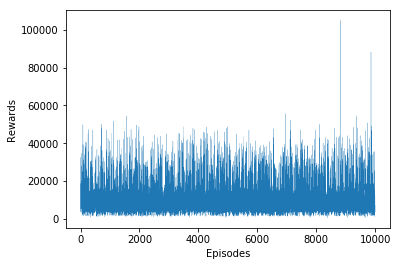

In [46]:
plt.plot(rewards, linewidth=0.2)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.gcf().subplots_adjust(left=0.15)
plt.savefig("output/graphs/training rewards.png", dpi=900)

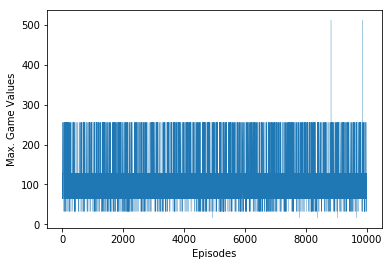

In [42]:
plt.plot(max_episode_values, linewidth=0.2)
plt.xlabel("Episodes")
plt.ylabel("Max. Game Values")
plt.savefig("output/graphs/training max game values.png", dpi=900)

In [45]:
# Save the reward lists for future use
with open("output/reward values/rewards.txt", "wb") as fp:   #Pickling
    pickle.dump(rewards, fp)

with open("output/reward values/max game values.txt", "wb") as fp:   #Pickling
    pickle.dump(max_episode_values, fp)

In [ ]:
# Test the policy network
num_games = 1000
rewards = []
choices = []
accepted_scores = []
RENDER_ENV = False

for each_game in range(num_games):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    while True:
        if RENDER_ENV:
            sleep(0.5)
            clear_output()
            env.display_state()
        #env.render()
        if len(prev_obs)==0:
            action = random.randrange(0,4)
        else:
            action = PG.choose_action(prev_obs).item()
                
        choices.append(action)
        new_observation, reward, done, info = env.step(action)
        new_observation = np.array(np.array(new_observation).flatten().tolist())

        # check if it is unfeasible move
        if np.array_equal(new_observation, prev_obs):
            # use another random move
            action = random.randrange(0,4)
            new_observation, reward, done, info = env.step(action)
            new_observation = convertTo1D(new_observation)
        
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        
        score+=reward
        if done: break
        
    if each_game%100 == 0: print(each_game)
    rewards.append(score)
    accepted_scores.append(env.highest_score())

print('Average Score:',sum(rewards)/len(rewards))
print('choice 0:{} choice 1:{} choice 2:{} choice 3:{}'.format(choices.count(0)/len(choices),choices.count(1)/len(choices), choices.count(2)/len(choices), choices.count(3)/len(choices)))
print(Counter(accepted_scores))

0
100
200
300
